In [1]:
pip install lark-parser

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install lark-parser
#pip install pydot
#pip install pillow

from lark import Lark,Tree, Token
import pydot
from PIL import Image
from functools import reduce

process_grammar = r"""
?start: xor

?xor: parallel
    | xor "^" parallel -> xor
    | xor "^" "[" NAME "]" parallel -> xor_probability

?parallel: sequential
    | parallel "||" sequential  -> parallel

?sequential: region
    | sequential "," region -> sequential

?region: 
     | NAME   -> task
     | "(" xor ")"

%import common.CNAME -> NAME
%import common.NUMBER
%import common.WS_INLINE

%ignore WS_INLINE
"""

l = Lark(process_grammar, parser='lalr')
def get_tasks(t):
    trees = [subtree for subtree in t.iter_subtrees()]
    v = {subtree.children[0].value for subtree in   filter(lambda x: x.data == 'task', trees)}
    return v

def dot_tree(t, id=0, prob={}, imp={}):
    if type(t) == Token:
        label = (t.value)
        impact =  f", {imp[label]}" if label in imp  else  ""  
        return f'node_{id}[label="{label}{impact}"];', id
    if type(t) == Tree:
        label = (t.data)
        code = ""
        last_id = id
        child_ids = []
        for i, c in enumerate(t.children):
            dot_code, last_id = dot_tree(c, last_id, prob, imp)
            code += f'\n {dot_code}'
            child_ids.append(last_id)
            last_id += 1
        code += f'\n node_{last_id}[label="{label}"];'
        edge_labels = ['','',''] 
        if label == "xor_probability":
            prob_key = t.children[1].value
            edge_labels = [f'{prob[prob_key] if prob_key  in prob else 0.5 }','',
                           f'{1 - prob[prob_key] if prob_key  in prob else 0.5 }'] 
        for ei,i in enumerate(child_ids):
            edge_label = edge_labels[ei]
            code += f'\n node_{last_id} -> node_{i} [label="{edge_label}"];'
        return code, last_id  

def print_tree(tree, outfile="out.png"):
    dot_string = "digraph my_graph{"+ tree[0] +"}"
    graphs = pydot.graph_from_dot_data(dot_string)
    graph = graphs[0]
    graph.write_png(outfile)
    return Image.open(outfile)
         

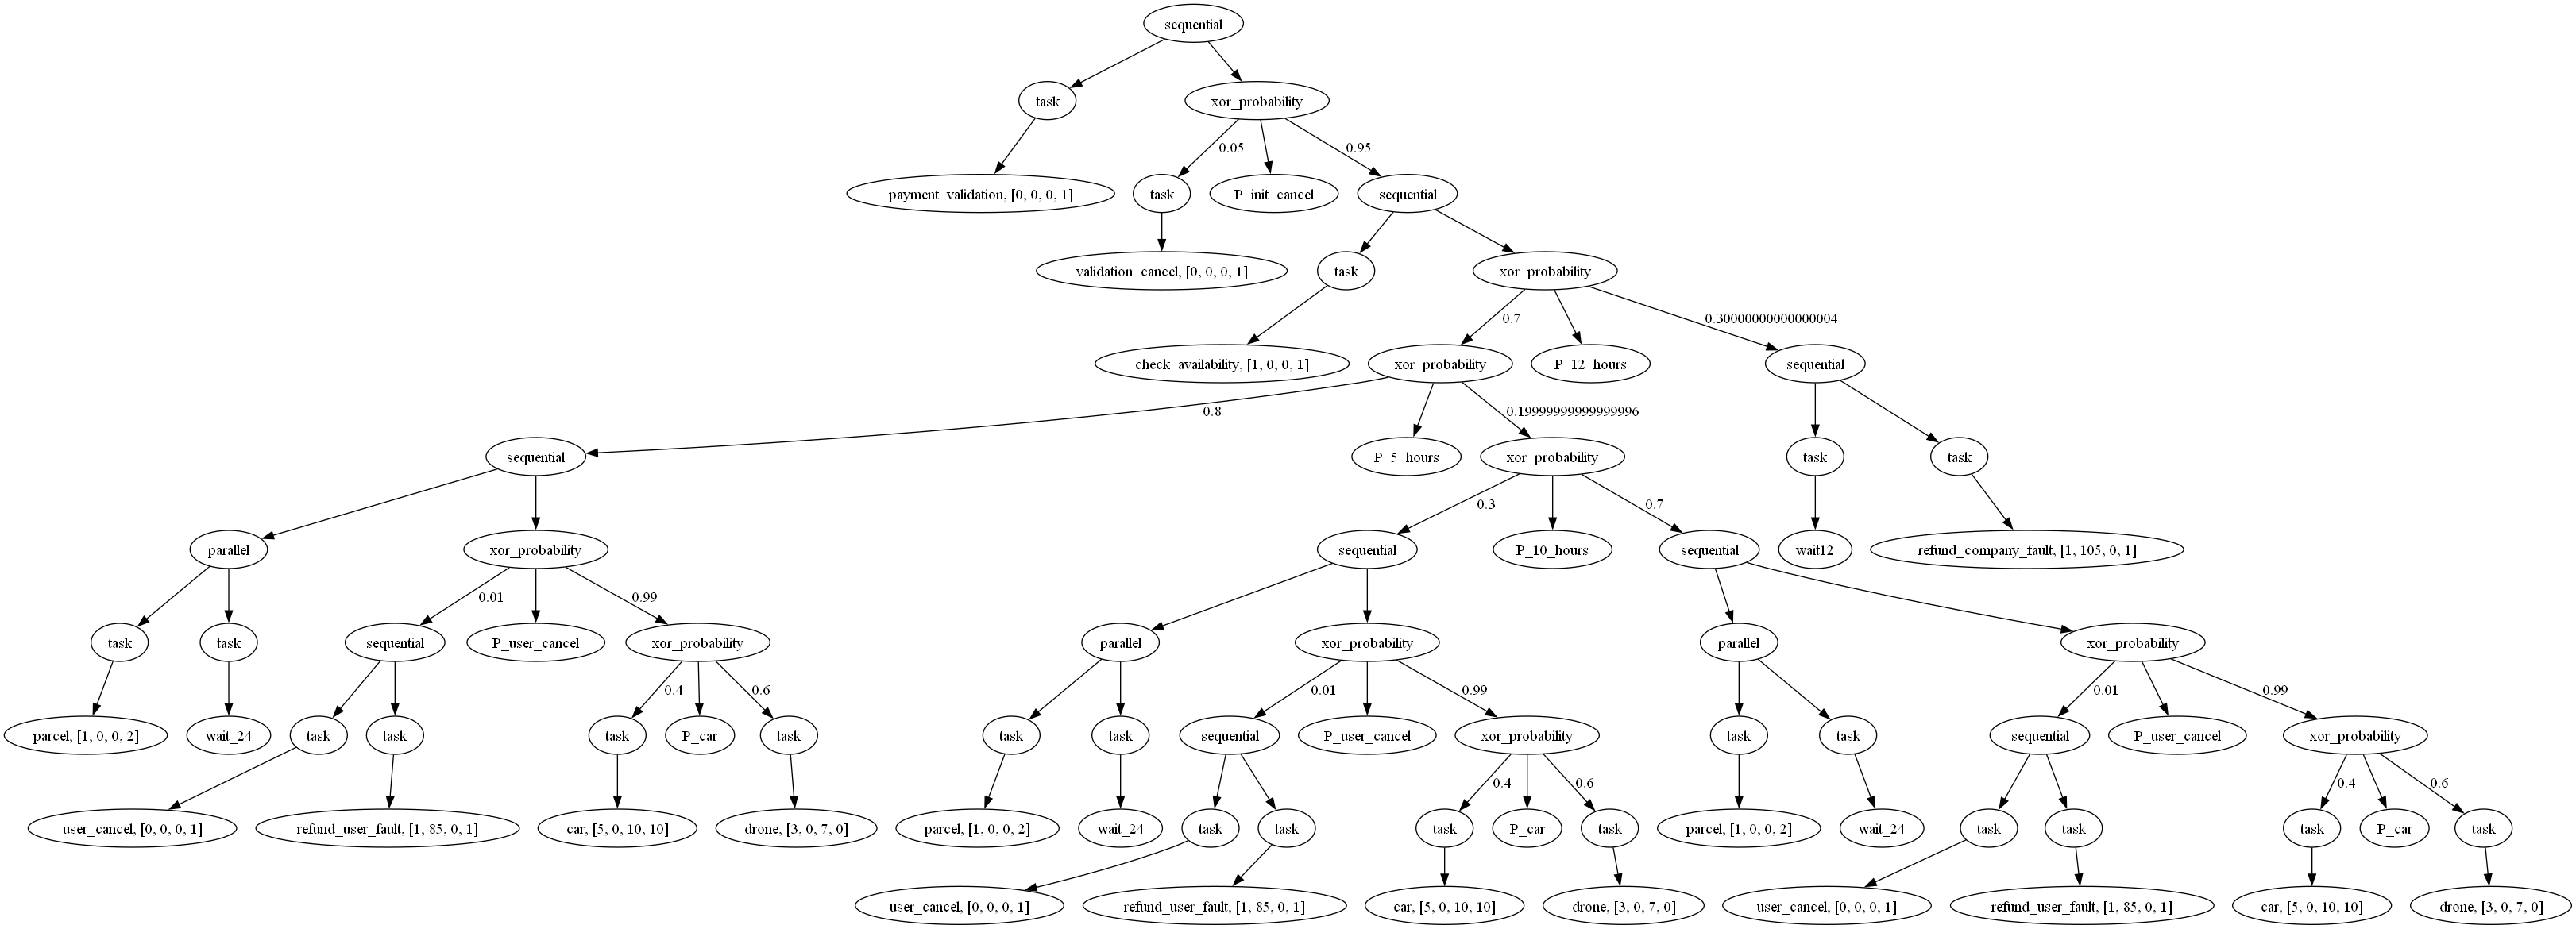

In [3]:
b1r2 = "( parcel || wait_24 ) , ( ( user_cancel, refund_user_fault ) ^[P_user_cancel] ( car ^[P_car] drone) )  "
b1r1 = f'check_availability, (( {b1r2} ^[P_5_hours] ({b1r2} ^[P_10_hours] {b1r2}) ) ^[P_12_hours] (wait12, refund_company_fault))'
b1  = f'payment_validation, ( validation_cancel ^[P_init_cancel] {b1r1} )'
b1t = l.parse(b1)
b1i = {"car":[5,0,10,10],"drone":[3,0,7,0],"payment_validation":[0,0,0,1],"validation_cancel":[0,0,0,1],"check_availability":[1,0,0,1],"refund_company_fault":[1,105,0,1,],"refund_user_fault":[1,85,0,1,],"parcel":[1,0,0,2,],"user_cancel":[0,0,0,1,]}
b1p = {"P_init_cancel": 0.05, "P_12_hours": 0.7, "P_5_hours": 0.8, "P_10_hours": 0.3, "P_car": 0.4, "P_user_cancel": 0.01}
print_tree( dot_tree(b1t, 0, b1p, b1i))

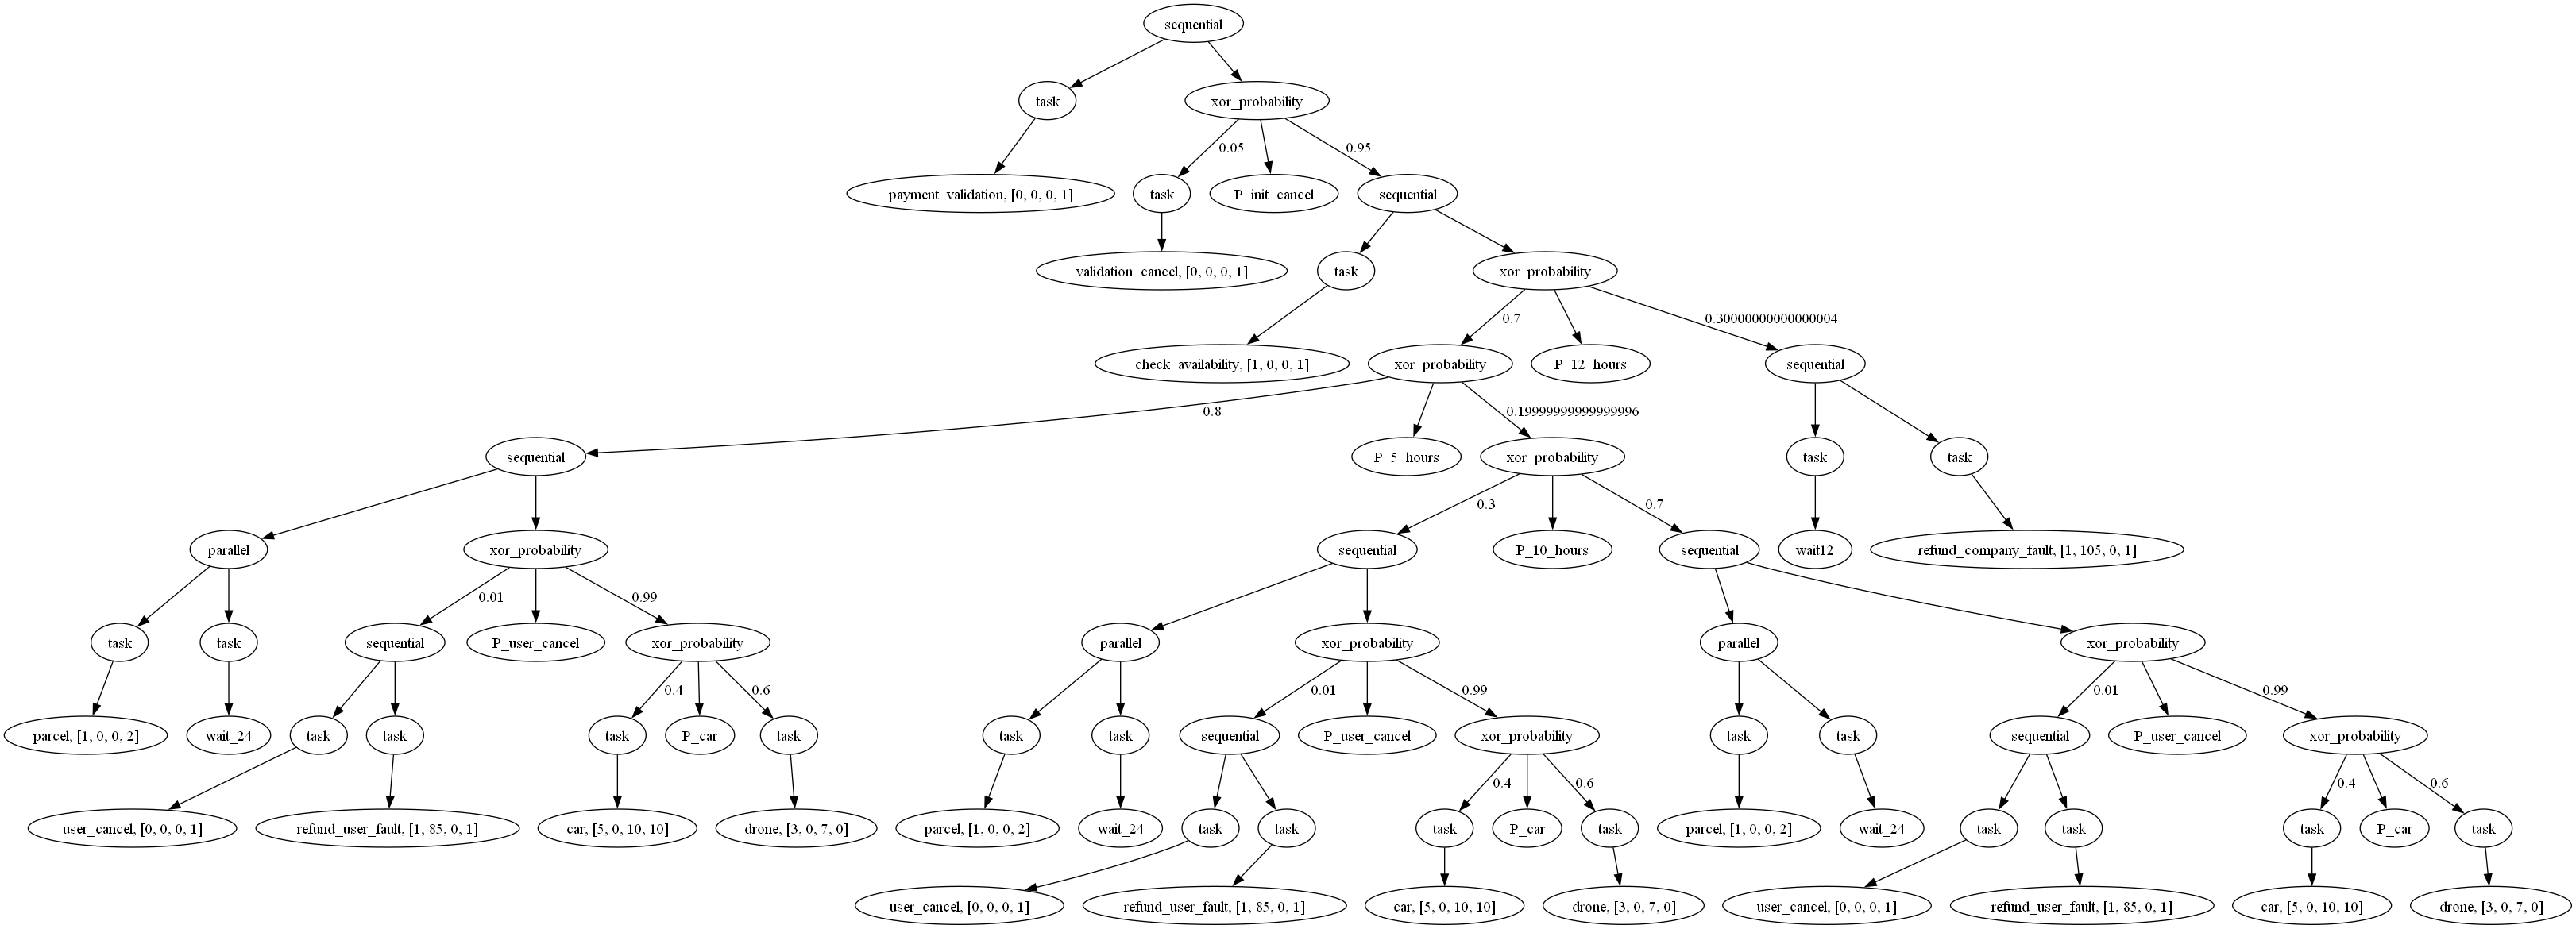

In [4]:
B2 = "check_availability,( cancel_company ^[P_init_cancel] ( confirmation,( (wait24, user_cancel, refund_user_fault )^[P_user_cancel] (update, payment_validation, parcel, ( car ^[pcar] drone )  )  )  )  )"
b2t = l.parse(B2)
b2i = {"car":[5,0,10,10],"drone":[3,0,7,0],"payment_validation":[0,0,0,1],"confirmation":[1,0,0,1],"check_availability":[1,0,0,1],"refund_user_fault":[1,85,0,1,],"parcel":[1,0,0,2,],"user_cancel":[0,0,0,1,],"cancel_company":[0,0,0,1,]}
b2p = {"P_init_cancel": 0.4, "P_car": 0.4, "P_user_cancel": 0.3}
print_tree( dot_tree(b1t, 0, b1p, b1i))

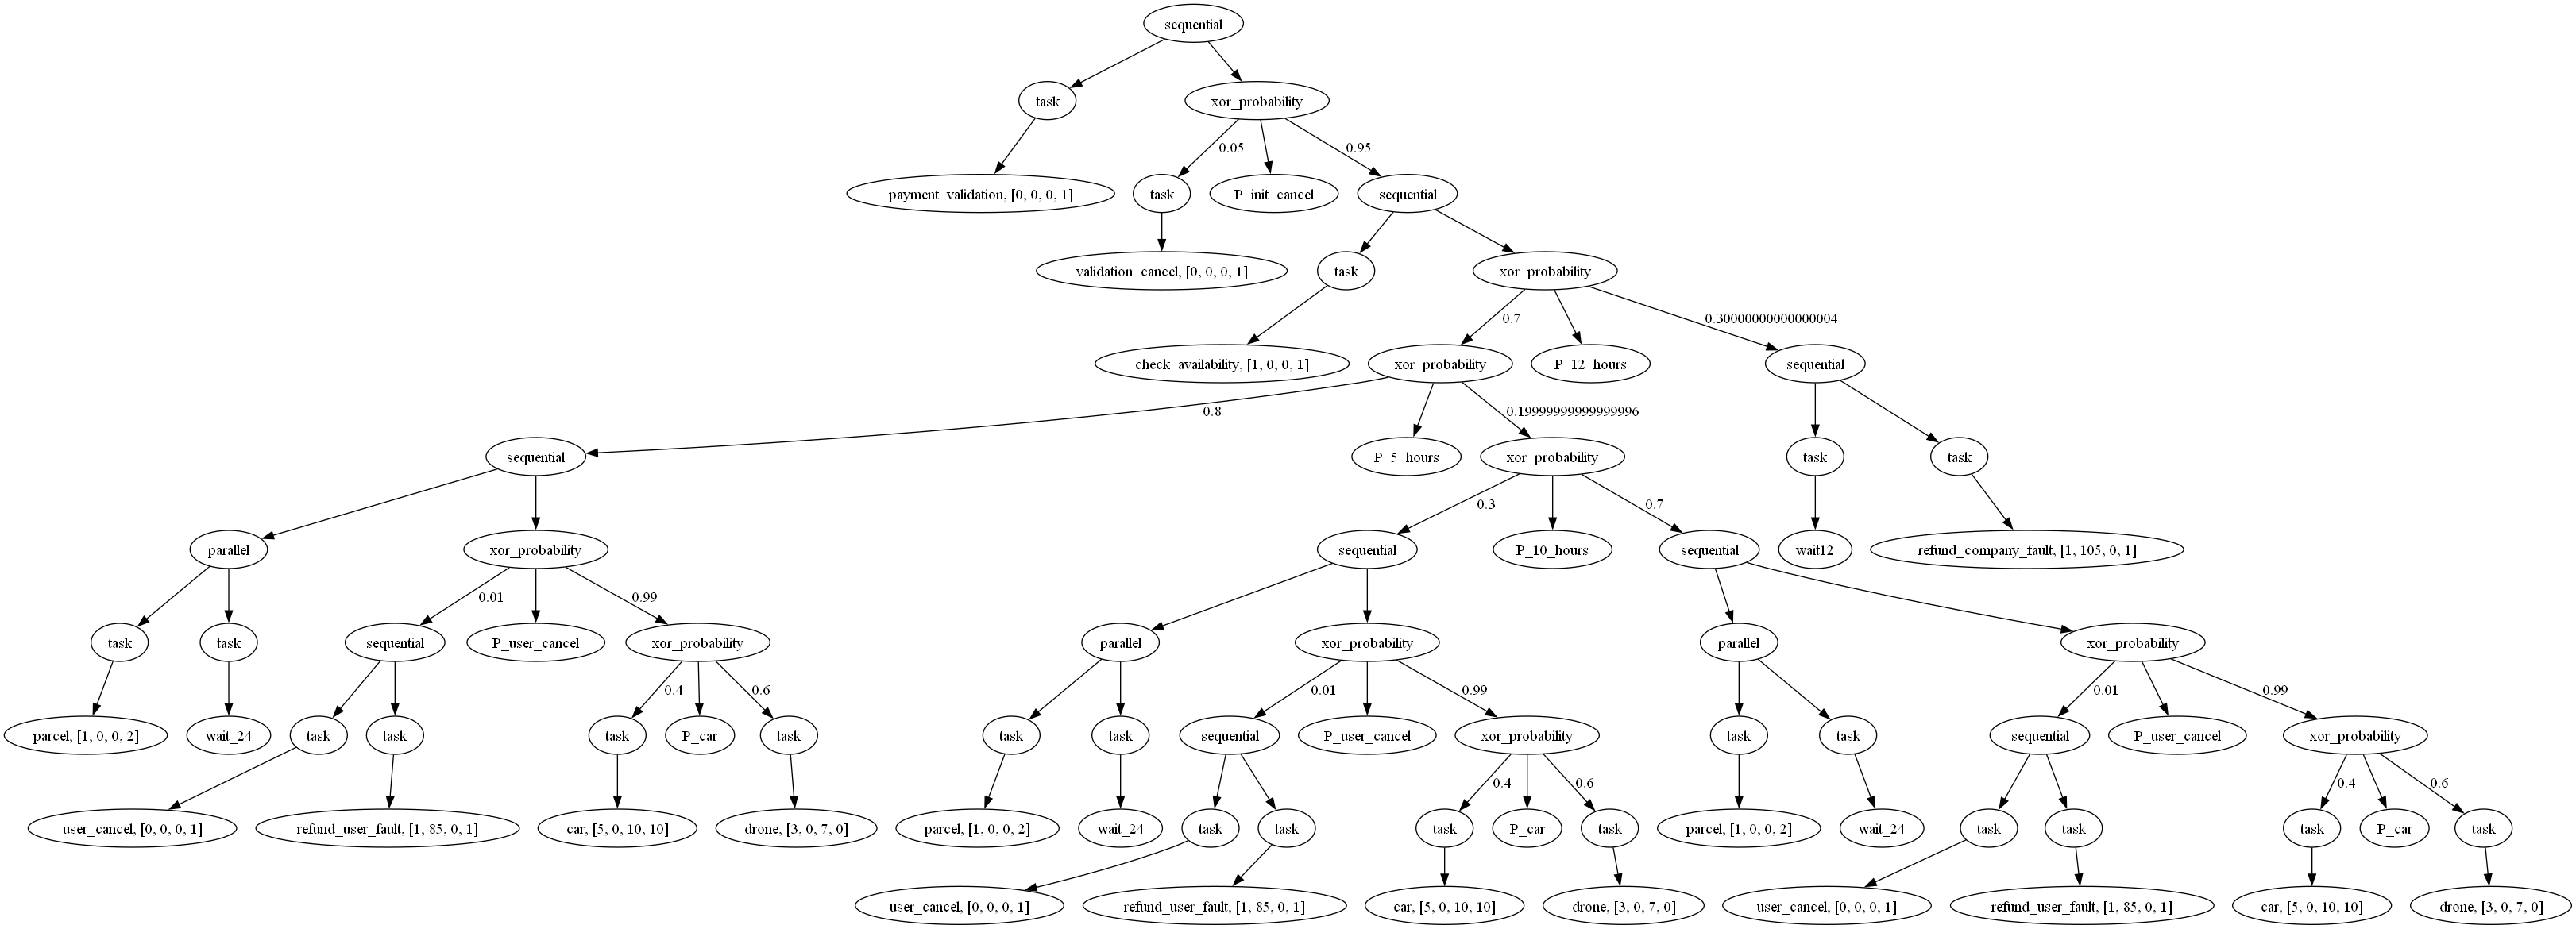

In [5]:
b3r2= "( parcel, wait_24, user_cancel, refund_user_fault  )   ^[P_contact_customer] (( contact_customer ) ^[P_user_cancel] ( car ^[P_car] drone) )  "
b3r1= f'check_availability, (({b3r2} ^[P_5_hours] ({b3r2} ^[P_10_hours] {b3r2}) ) ^[P_12_hours] (wait12, refund_company_fault))' 
b3  = f'payment_validation,( validation_cancel ^[P_init_cancel]{b3r1})' 
b3t = l.parse(b3)
b3i = {"car":[5,0,10,10],"drone":[3,0,7,0],"payment_validation":[0,0,0,1],"refund_user_fault":[1,85,0,1],"parcel":[1,0,0,2],"user_cancel":[0,0,0,1],"cancel_company":[0,0,0,1],"contact_customer":[0,0,0,1]}
b3p = {"P_init_cancel": 0.05, "P_12_hours": 0.7, "P_5_hours": 0.8, "P_10_hours": 0.3, "P_car": 0.4, "P_user_cancel": 0.01, "P_contact_customer": 0.01}
print_tree( dot_tree(b1t, 0, b1p, b1i))

In [6]:
tr = b1t.children[1]
t= tr.children[1]
t.value, tr
tr.children[0]

Tree('task', [Token('NAME', 'validation_cancel')])

In [7]:
# IT returns the number_traces, sum/min/max_vector_impacts

def sum_lists(l1, l2):
   return [a+b for a, b in zip(l1, l2)]

def pairwise_min_lists(l1, l2):
   return  [min(a,b) for a,b in zip(l1,l2)]

def pairwise_max_lists(l1, l2):
   return  [max(a,b) for a,b in zip(l1,l2)]

def scalar_mul(k, l):
   return  [k*a for a in l]    

def compute_impact_vector(tree, task_impacts, probabilities):
    if(tree.data == 'sequential') or (tree.data == 'parallel'):
        num_traces_1, sum_impacts_1, min_impact_1, max_impacts_1 = compute_impact_vector(tree.children[0], task_impacts, probabilities)
        num_traces_2, sum_impacts_2, min_impact_2, max_impacts_2 = compute_impact_vector(tree.children[1], task_impacts, probabilities)
        r = (num_traces_1 * num_traces_2, 
            scalar_mul(num_traces_1  *  num_traces_2,sum_lists(sum_impacts_1 + sum_impacts_2)),
            sum_lists(min_impact_1 , min_impact_2), 
            sum_lists(max_impacts_1 , max_impacts_2))
    
    if (tree.data == 'task'):
        impacts = min_impact = max_impacts = task_impacts[tree.children[0].value]
        num_traces = 1
        r = (num_traces, impacts, min_impact, max_impacts)
        
    if tree.data == 'xor':
        num_traces_1, impacts_1, min_impact_1, max_impacts_1 = compute_impact_vector(tree.children[0], task_impacts, probabilities)
        num_traces_2, impacts_2, min_impact_2, max_impacts_2 = compute_impact_vector(tree.children[1], task_impacts, probabilities)
        r =  (num_traces_1 + num_traces_2,
              sum_lists(impacts_1, impacts_2),
              pairwise_min_lists(min_impact_1,min_impact_2),
              pairwise_max_lists(max_impacts_1, max_impacts_2))
    
    if tree.data == 'xor_probability':
        probability = probabilities[tree.children[1].value] if tree.children[1].value in probabilities else 0.5
        p,q =  odds(probability)
        num_traces_1, impacts_1, min_impact_1, max_impacts_1 = compute_impact_vector(tree.children[0], task_impacts, probabilities)
        num_traces_2, impacts_2, min_impact_2, max_impacts_2 = compute_impact_vector(tree.children[2], task_impacts, probabilities)
        r = ( p*num_traces_1 + q*num_traces_2, 
              sum_lists(scalar_mul(p , impacts_1),scalar_mul(q, impacts_2)),
              pairwise_min_lists(min_impact_1,min_impact_2),
              pairwise_max_lists(max_impacts_1, max_impacts_2))
    
    return r

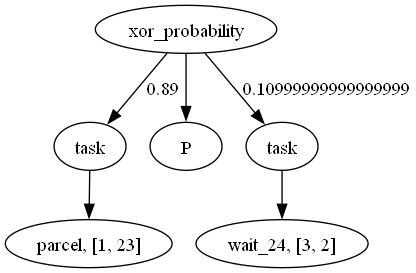

In [8]:
#test with simple task
test1 = "( parcel ^[P] wait_24 )"
test1 = l.parse(test1)
print_tree( dot_tree(test1, 0, {"P":0.89}, {"parcel": [1,23],"wait_24":[3, 2]}))

In [9]:
from fractions import Fraction

def get_digits(f):
    return len(str(f).split(".")[1])

def odds(p):
    l = get_digits(p)
    fo = int(p * (10**l))
    so = int((10**(l)) - fo)
    f  = Fraction(fo,so)
    return (f.numerator, f.denominator)

o = odds(0.90)
o, o[0] + o[1]

((9, 1), 10)

In [10]:
compute_impact_vector(test1,   {"parcel": [1,23],"wait_24":[3, 2]},{"P":0.89})

(100, [122, 2069], [1, 2], [3, 23])

In [11]:
test2 = "(check_availability ^[P_init_cancel] confirmation )"
test2 = l.parse(test2)
print_tree(dot_tree( test2, 0,{"check_availability":[2,35],"confirmation":[23,4]}, {"P_init_cancel": 0.3}))
#b2i = {"check_availability":[1,0],"cancel_company":[0,1]}
#b2p = {"P_init_cancel": 0.4, "P_car": 0.4, "P_user_cancel": 0.3}
compute_impact_vector(test2,{"check_availability":[1,0],"confirmation":[5,45]}, {"P_init_cancel": 0.3})
#print_tree( dot_tree(test2,{"check_availability":[1,0],"cancel_company":[0,1]}, {"P_user_cancel": 0.3}))

(10, [38, 315], [1, 0], [5, 45])

In [12]:
test3 = "(check_availability ^confirmation )"
test3 = l.parse(test3)
print_tree(dot_tree( test3, 0,{"check_availability":[2,35],"confirmation":[23,4]},))
result=compute_impact_vector(test3,{"check_availability":[1,0],"confirmation":[5,45]},{"P":0.5})

result[1]

[6, 45]

In [13]:
test4 = "(check_availability)"
test4 = l.parse(test4)
print_tree(dot_tree( test4, 0,{"check_availability":[1,0]}))
result1=compute_impact_vector(test4,{"check_availability":[1,0]},0)
result1[1]

[1, 0]

In [14]:
# similarity measure on two impacts 

import numpy as np
def cosine_similarity(B1, B2):
    dot_product = np.dot(B1, B2)
    norm_B1 = np.linalg.norm(B1)
    norm_B2 = np.linalg.norm(B2)
    min_norm = min(norm_B1, norm_B2)
    max_norm = max(norm_B1, norm_B2)

    similarity = dot_product * (min_norm / max_norm)
    return similarity

def Euclidean_similarity(B1, B2, H_min, H_max):
    d_B1_B2 = [abs(a - b) for a, b in zip(B1, B2)]
    d_H_min_H_max = [abs(a - b) for a, b in zip(H_min, H_max)]
    similarity = 1 - (sum(d_B1_B2) / sum(d_H_min_H_max))
    return similarity


In [15]:
# Cosine Similarity
B1=(result[1])
B2=(result1[1])
similarity = cosine_similarity(B1,B2)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.13216372009101796


In [16]:
# Euclidean_similarity 
B1 = (result[1])
B2 = (result1[1])
H_min = ([min(a, b) for a, b in zip(result[2], result1[2])])
H_max = ([max(a, b) for a, b in zip(result[3], result1[3])])

similarity = Euclidean_similarity(B1, B2, H_min, H_max)
print("Euclidean_similarity:", similarity)

Euclidean_similarity: -0.020408163265306145


In [17]:
#task ,padding impact,padding probabaility 
def get_tasks(tree):
    if type(tree) == Token:
        return set([])
    if (tree.data == 'task'):
        return set([tree.children[0].value])
    else:
        return reduce(lambda x,y: x.union(y), [get_tasks(c) for c in tree.children])
         
def pad_zero_impacts(tree, impacts):
    tasks = get_tasks(tree)
    if len(impacts.keys()) == 0:
        return { t:[0] for t in tasks }
    else: 
        impact_dim = len(list(impacts.values())[0])
        return {t:[ 0 for _ in range(impact_dim)] for t in tasks} | impacts
    
def pad_prob(tree, probabilities):
    tasks = get_tasks(tree)
    if len(probabilities.keys()) == 0:
        return {t: [0] for t in tasks}
    else:
        impact_dim = list(probabilities.values())[0]
        return {t: [0 for _ in range(int(impact_dim))] for t in tasks} | probabilities

In [18]:
def pad_prob(tree, probabilities):
    tasks = get_tasks(tree)
    if len(probabilities.keys()) == 0:
        return {t: 0.5 for t in tasks}
    else:
        impact_dim = list(probabilities.values())[0]
        return {t: [0 for _ in range(int(impact_dim))] for t in tasks} | probabilities

pad_prob(b1t, b1p)

{'check_availability': [],
 'user_cancel': [],
 'car': [],
 'validation_cancel': [],
 'wait12': [],
 'drone': [],
 'wait_24': [],
 'refund_user_fault': [],
 'parcel': [],
 'payment_validation': [],
 'refund_company_fault': [],
 'P_init_cancel': 0.05,
 'P_12_hours': 0.7,
 'P_5_hours': 0.8,
 'P_10_hours': 0.3,
 'P_car': 0.4,
 'P_user_cancel': 0.01}

In [19]:
get_tasks(b1t)


{'car',
 'check_availability',
 'drone',
 'parcel',
 'payment_validation',
 'refund_company_fault',
 'refund_user_fault',
 'user_cancel',
 'validation_cancel',
 'wait12',
 'wait_24'}

In [20]:
pad_zero_impacts(b1t, b1i)


{'check_availability': [1, 0, 0, 1],
 'user_cancel': [0, 0, 0, 1],
 'car': [5, 0, 10, 10],
 'validation_cancel': [0, 0, 0, 1],
 'wait12': [0, 0, 0, 0],
 'drone': [3, 0, 7, 0],
 'wait_24': [0, 0, 0, 0],
 'refund_user_fault': [1, 85, 0, 1],
 'parcel': [1, 0, 0, 2],
 'payment_validation': [0, 0, 0, 1],
 'refund_company_fault': [1, 105, 0, 1]}